In [15]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(RUVSeq))
suppressPackageStartupMessages(library(EDASeq))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(RColorBrewer))


In [11]:
# Rewrite DESeq2 plotPCA function to specify which PC to plot
plotPCA_ = function(object, intgroup="condition", ntop=500, returnData=FALSE, pcX=1, pcY=2, ignoreReps=FALSE)
{
  # calculate the variance for each gene
  rv <- rowVars(assay(object))

  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))

  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }

  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])
  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
    
  if (returnData) {
    attr(d, "percentVar") <- c(percentVar[pcX], percentVar[pcY])
    return(d)
  }
  rep <- colData(object)[['rep']]
#   rep <- row.names(colData(dds))
  if (!ignoreReps){
      # Add replicate info
#       rep <- colData(object)[['rep']]

        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, rep=rep, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group", shape="rep")) + geom_point(size=2) + 
        xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  } else {
#       batch <- as.factor(colData(object)[['batch']])
        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group")) + 
          geom_point(size=2) +
          geom_text(aes(label=rep),hjust=0, vjust=0) +
          xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  }
#     + coord_fixed()
}


In [9]:
### countData

countData <- read.csv('/data/reddylab/Revathy/collabs/Keith/Th1/data/rna_seq/counts/Th1.count.txt', sep='\t')
countData <- countData[,-1]
rownames(countData) <- countData[,1]
countData[,1] <- NULL
countData <- as.matrix(subset(countData))

### colData

colData <- data.frame(col1 = c('KS191.Th1.0hr.rep1','KS191.Th1.0hr.rep2','KS191.Th1.0hr.rep3',
                               'KS191.Th1.2hr.rep1','KS191.Th1.2hr.rep2','KS191.Th1.2hr.rep3',
                               'KS191.Th1.16hr.rep1','KS191.Th1.16hr.rep2','KS191.Th1.16hr.rep3',
                               'KS191.Th1.24hr.rep1','KS191.Th1.24hr.rep2','KS191.Th1.24hr.rep3',
                               'KS191.Th1.48hr.rep1','KS191.Th1.48hr.rep2','KS191.Th1.48hr.rep3',
                               'KS191.Th1.72hr.Sorted.rep1','KS191.Th1.72hr.Sorted.rep2','KS191.Th1.72hr.Sorted.rep3'),
                     condition = c('KS191.Th1.0hr','KS191.Th1.0hr','KS191.Th1.0hr',
                               'KS191.Th1.2hr','KS191.Th1.2hr','KS191.Th1.2hr',
                               'KS191.Th1.16hr','KS191.Th1.16hr','KS191.Th1.16hr',
                               'KS191.Th1.24hr','KS191.Th1.24hr','KS191.Th1.24hr',
                               'KS191.Th1.48hr','KS191.Th1.48hr','KS191.Th1.48hr',
                               'KS191.Th1.72hr.Sorted','KS191.Th1.72hr.Sorted','KS191.Th1.72hr.Sorted'),
                     rep = c('rep1','rep2','rep3','rep1','rep2','rep3',
                             'rep1','rep2','rep3','rep1','rep2','rep3',
                             'rep1','rep2','rep3','rep1','rep2','rep3'), stringsAsFactors = TRUE)
rownames(colData) <- colData[,1]
colData[,1] <- NULL


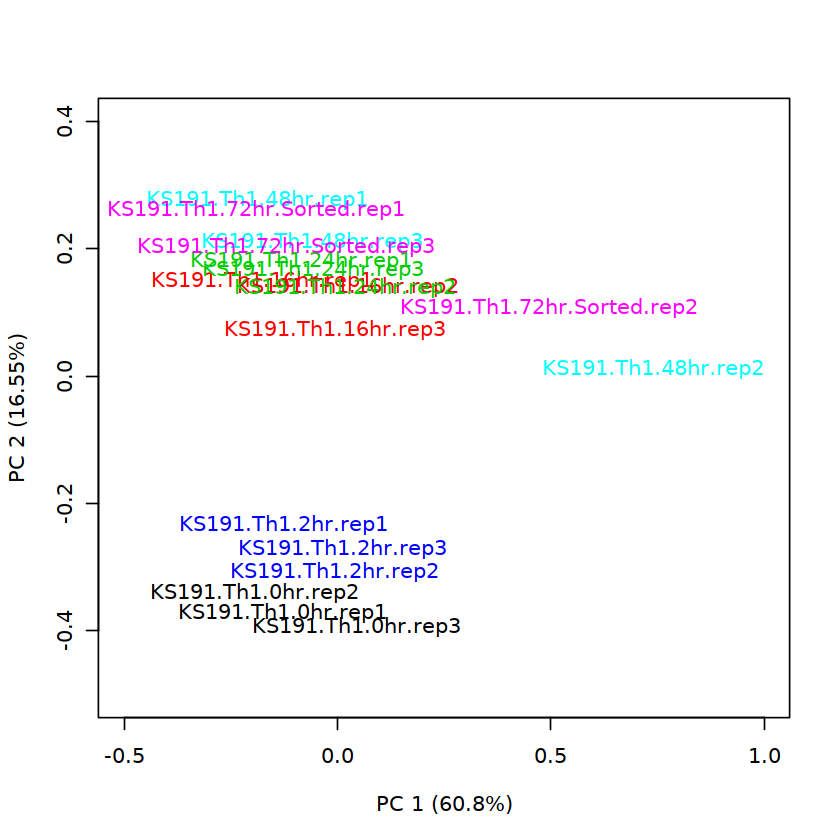

In [14]:
### expression set

set <- newSeqExpressionSet(counts=countData, phenoData=colData)
idx <- rowSums(counts(set) > 5)>=2
set <- set[idx, ]

plotPCA(set, col = as.numeric(colData$condition), adj = 0.5, 
        ylim = c(-0.5, 0.4), xlim = c(-0.5, 1.0))

In [1]:
### countData

countData_Th2 <- read.csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/counts/Th2.count.txt', sep='\t')
countData_Th2 <- countData_Th2[,-1]
rownames(countData_Th2) <- countData_Th2[,1]
countData_Th2[,1] <- NULL
countData_Th2 <- as.matrix(subset(countData_Th2))

### colData

col1_colData <- as.vector(colnames(countData_Th2))
cond_colData <- gsub('(.*)\\..*', '\\1', col1_colData)
rep_colData <- gsub('.*\\.(.*)','\\1',col1_colData)

colData_Th2 <- data.frame(condition = cond_colData,
                     rep = rep_colData, stringsAsFactors = TRUE)

rownames(colData_Th2) <- col1_colData

colnames(countData_Th2)

[1] "KS88.Th2.0hr.rep1"       "KS88.Th2.0hr.rep2"      
 [3] "KS88.Th2.0hr.rep3"       "KS88.Th2.0hr.rep4"      
 [5] "KS88.Th2.2hr.rep1"       "KS88.Th2.2hr.rep2"      
 [7] "KS88.Th2.2hr.rep3"       "KS88.Th2.2hr.rep4"      
 [9] "KS88.Th2.16hr.rep1"      "KS88.Th2.16hr.rep2"     
[11] "KS88.Th2.16hr.rep3"      "KS88.Th2.16hr.rep4"     
[13] "KS88.Th2.24hr.rep1"      "KS88.Th2.24hr.rep2"     
[15] "KS88.Th2.24hr.rep3"      "KS88.Th2.24hr.rep4"     
[17] "KS88.Th2.48hr.rep1"      "KS88.Th2.48hr.rep2"     
[19] "KS88.Th2.48hr.rep3"      "KS88.Th2.48hr.rep4"     
[21] "KS88.Th2.72hr.Sort.rep1" "KS88.Th2.72hr.Sort.rep2"
[23] "KS88.Th2.72hr.Sort.rep3" "KS88.Th2.72hr.Sort.rep4"

In [4]:
### expression set

Th2set <- newSeqExpressionSet(counts=countData_Th2, phenoData=colData_Th2)
Th2idx <- rowSums(counts(Th2set) > 5)>=2
Th2set <- Th2set[Th2idx, ]

plotPCA(vsd, intgroup=c('condition'))

ERROR: Error in plotPCA(vsd, intgroup = c("condition")): object 'vsd' not found


In [48]:
Th1dds <- DESeqDataSetFromMatrix(countData = countData, 
                              colData = colData,
                              design = ~ rep + condition)
Th1dds <- DESeq(Th1dds)
Th1vsd <- vst(Th1dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


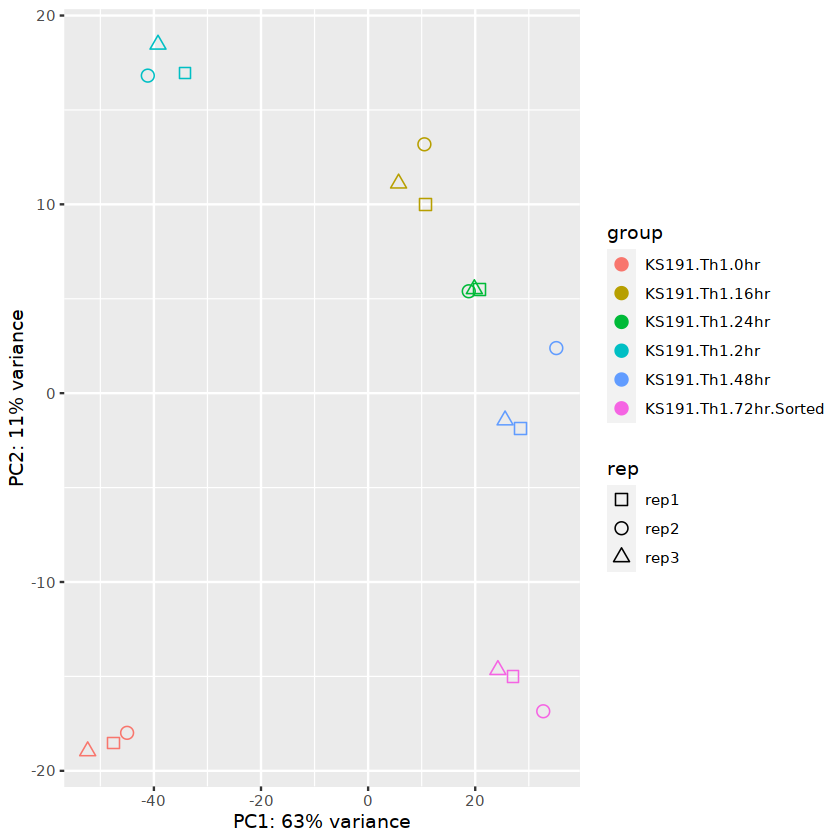

In [49]:
plotPCA_(Th1vsd, intgroup=c('condition'), ntop=500, pcX=1, pcY=2)

In [5]:
dds <- DESeqDataSetFromMatrix(countData = countData_Th2, 
                              colData = colData_Th2,
                              design = ~ rep + condition)
dds <- DESeq(dds)
vsd <- vst(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


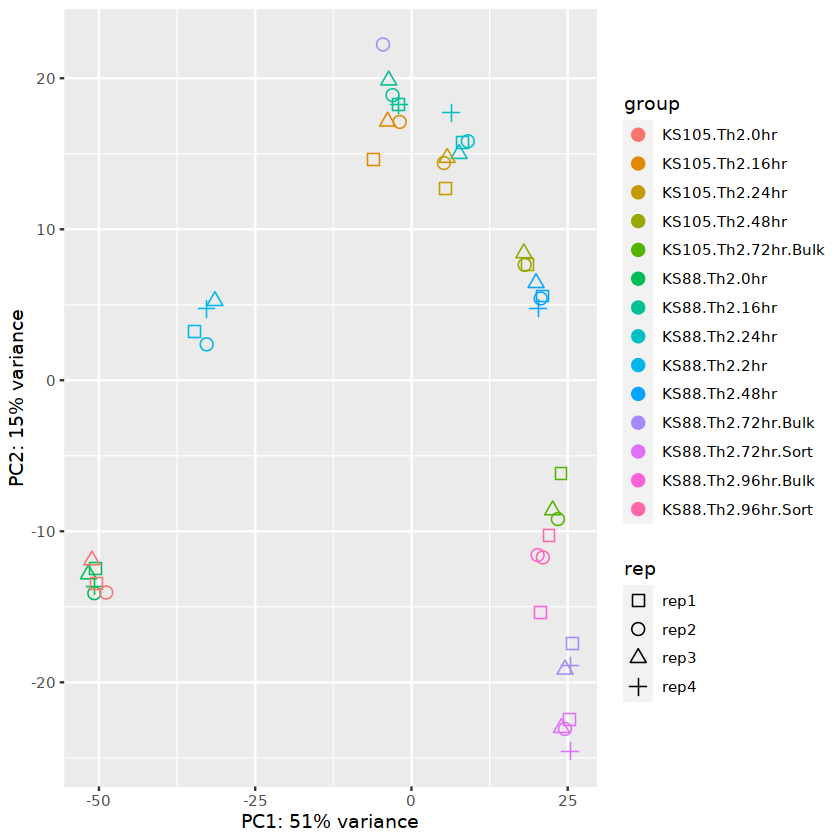

In [6]:
plotPCA_(vsd, intgroup=c('condition'), ntop=500, pcX=1, pcY=2)

#### subset countData and colData for Th2 just for 72hrs and 96hrs

In [8]:
countData_Th2 <- read.csv('/data/reddylab/Revathy/collabs/Keith/Th2/data/rna_seq/counts/Th2.count.txt', sep='\t')
countData_Th2 <- countData_Th2[,-1]
rownames(countData_Th2) <- countData_Th2[,1]
countData_Th2[,1] <- NULL

var <- c('KS88.Th2.72hr.Bulk.rep1','KS88.Th2.72hr.Bulk.rep2','KS88.Th2.72hr.Bulk.rep3','KS88.Th2.72hr.Bulk.rep4',
         'KS105.Th2.72hr.Bulk.rep1','KS105.Th2.72hr.Bulk.rep2','KS105.Th2.72hr.Bulk.rep3',
         'KS88.Th2.72hr.Sort.rep1','KS88.Th2.72hr.Sort.rep2','KS88.Th2.72hr.Sort.rep3','KS88.Th2.72hr.Sort.rep4',
         'KS88.Th2.96hr.Bulk.rep1','KS88.Th2.96hr.Bulk.rep2','KS88.Th2.96hr.Sort.rep1','KS88.Th2.96hr.Sort.rep2')

countDataTh2_subset <- countData_Th2[var]
countDataTh2_subset <- as.matrix(subset(countDataTh2_subset))

col1_colData <- as.vector(colnames(countDataTh2_subset))
cond_colData <- gsub('(.*)\\..*', '\\1', col1_colData)
rep_colData <- gsub('.*\\.(.*)','\\1',col1_colData)

colDataTh2_subset <- data.frame(condition = cond_colData,
                     rep = rep_colData, stringsAsFactors = TRUE)

rownames(colDataTh2_subset) <- col1_colData

colDataTh2_subset

,condition,rep
KS88.Th2.72hr.Bulk.rep1,KS88.Th2.72hr.Bulk,rep1
KS88.Th2.72hr.Bulk.rep2,KS88.Th2.72hr.Bulk,rep2
KS88.Th2.72hr.Bulk.rep3,KS88.Th2.72hr.Bulk,rep3
KS88.Th2.72hr.Bulk.rep4,KS88.Th2.72hr.Bulk,rep4
KS105.Th2.72hr.Bulk.rep1,KS105.Th2.72hr.Bulk,rep1
KS105.Th2.72hr.Bulk.rep2,KS105.Th2.72hr.Bulk,rep2
KS105.Th2.72hr.Bulk.rep3,KS105.Th2.72hr.Bulk,rep3
KS88.Th2.72hr.Sort.rep1,KS88.Th2.72hr.Sort,rep1
KS88.Th2.72hr.Sort.rep2,KS88.Th2.72hr.Sort,rep2
KS88.Th2.72hr.Sort.rep3,KS88.Th2.72hr.Sort,rep3


In [9]:
dds_Th2_sub <- DESeqDataSetFromMatrix(countData = countDataTh2_subset, 
                              colData = colDataTh2_subset,
                              design = ~ rep + condition)
dds_Th2_sub <- DESeq(dds_Th2_sub)
vsd_Th2_sub <- vst(dds_Th2_sub)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


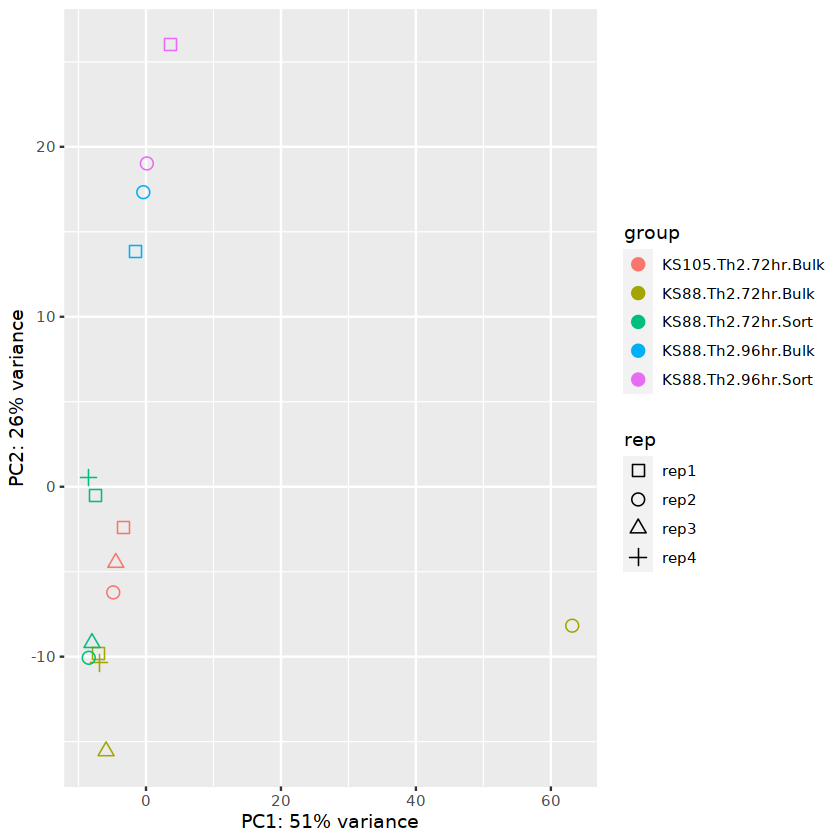

In [10]:
plotPCA_(vsd_Th2_sub, intgroup=c('condition'), ntop=500, pcX=1, pcY=2)

RUVSeq against timepoint zero

In [55]:


### countData
countData_for_00 <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/Th1_Th2_Th17_Treg_Th0.counts.txt', sep='\t')
countData_for_00 <- countData_for_00[,-1]
rownames(countData_for_00) <- countData_for_00[,1]
countData_for_00[,1] <- NULL
countData_for_00 <- as.matrix(subset(countData_for_00))

### colData

col1_colData_00 <- as.vector(colnames(countData_for_00))
cond_colData_00 <- gsub('(.*)\\..*', '\\1', col1_colData_00)
rep_colData_00 <- gsub('.*\\.(.*)','\\1',col1_colData_00)

colData_for_00 <- data.frame(condition = cond_colData_00,
                     rep = rep_colData_00, stringsAsFactors = TRUE)


rownames(colData_for_00) <- col1_colData_00

## create expression set for RUVSeq

set_for_00 <- newSeqExpressionSet(counts=countData_for_00,
                           phenoData = colData_for_00)
idx_for_00  <- rowSums(counts(set_for_00) > 5) >= 2
set_for_00 <- set_for_00[idx_for_00, ]

differences <- makeGroups(colData_for_00$condition)

set_ruv_00 <- RUVs(set_for_00, unique(rownames(set_for_00)), k=4, differences)
ruv_colData_for_00 <- pData(set_ruv_00)

#write.table(ruv_colData_for_00, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_data_Tcell.txt'), quote = FALSE, row.names=TRUE, sep='\t')

### colData

new_colData <- ruv_colData_for_00

### DESeq matrix

# dds <- DESeqDataSetFromMatrix(countData = countData_for_00, 
#                                  colData = new_colData, 
#                                  design = ~ W_1 + W_2 + rep + condition)

# references <- c('00hr','02hr','16hr','24hr','48hr')
# for (ref in references) {
#     dds$condition <- relevel(dds$condition, ref = paste0('mmTh0.Bulk.',ref))
#     dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 15, ]
#     dds <- estimateSizeFactors(dds)
#     dds <- estimateDispersions(dds, fitType='local')
#     dds <- nbinomWaldTest(dds, maxit=100000)
    
#     ##th2
#     result_th2 <- results(dds, contrast = c('condition',paste0('KS88.Th2.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
#     result_th2 <- result_th2[order(result_th2$padj),]
#     result_th2 <- lfcShrink(ddsruv, coef=paste0('condition_KS88.Th2.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
     write.table(result_th2, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th2.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
    
#     ##th17
#     result_th17 <- results(dds, contrast = c('condition',paste0('Th17.Bulk.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
#     result_th17 <- result_th17[order(result_th17$padj),]
#     result_th17 <- lfcShrink(dds, coef=paste0('condition_Th17.Bulk.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
#     write.table(result_th17, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th17.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
    
#     ##treg
#     result_treg <- results(dds, contrast = c('condition',paste0('mmTreg.Bulk.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
#     result_treg <- result_treg[order(result_treg$padj),]
#     result_treg <- lfcShrink(ddsruv, coef=paste0('condition_mmTreg.Bulk.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
#     write.table(result_treg, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/mmTreg.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
    
#     ##th1
#     result_th1 <- results(dds, contrast = c('condition',paste0('KS191.Th1.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
#     result_th1 <- result_th1[order(result_th1$padj),]
#     result_th1 <- lfcShrink(ddsruv, coef=paste0('condition_KS191.Th1.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
#     write.table(result_th1, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th1.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
# }


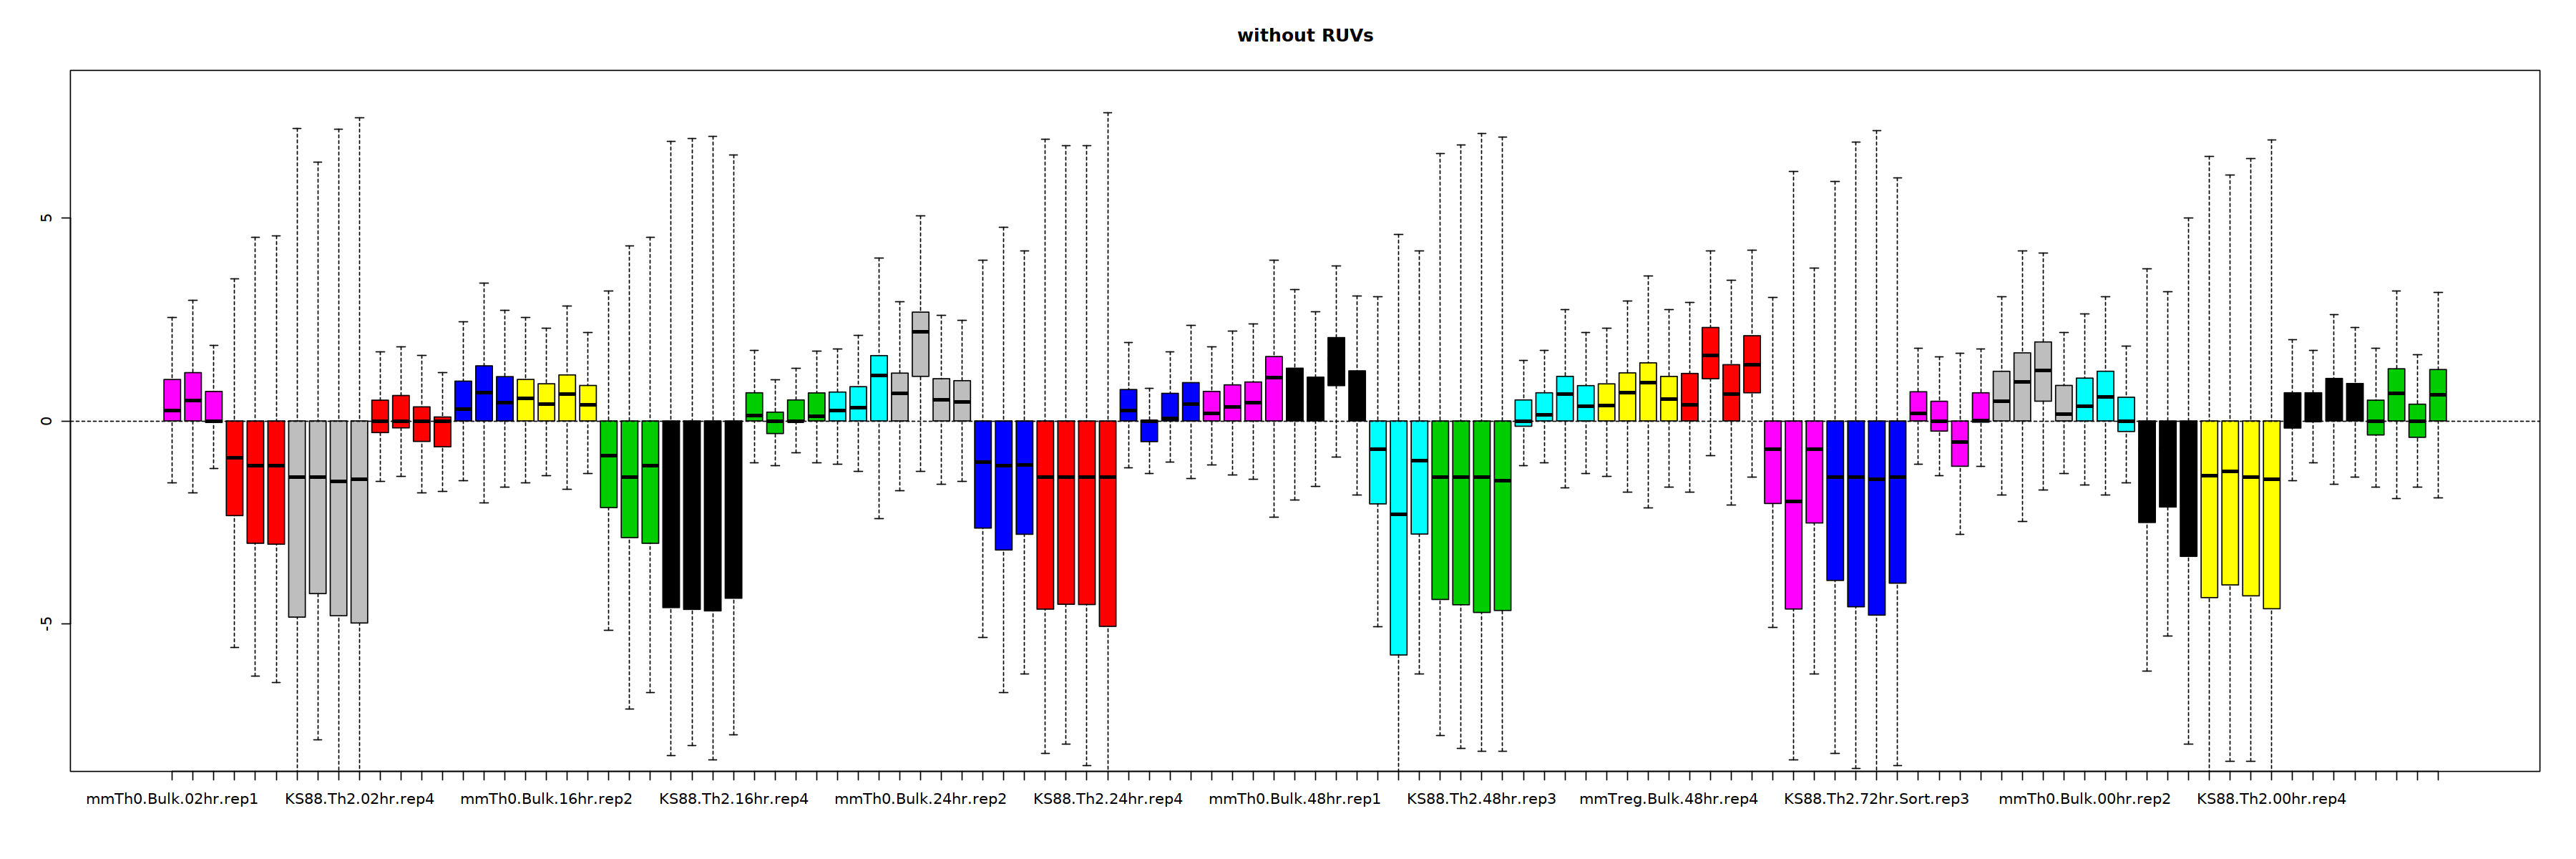

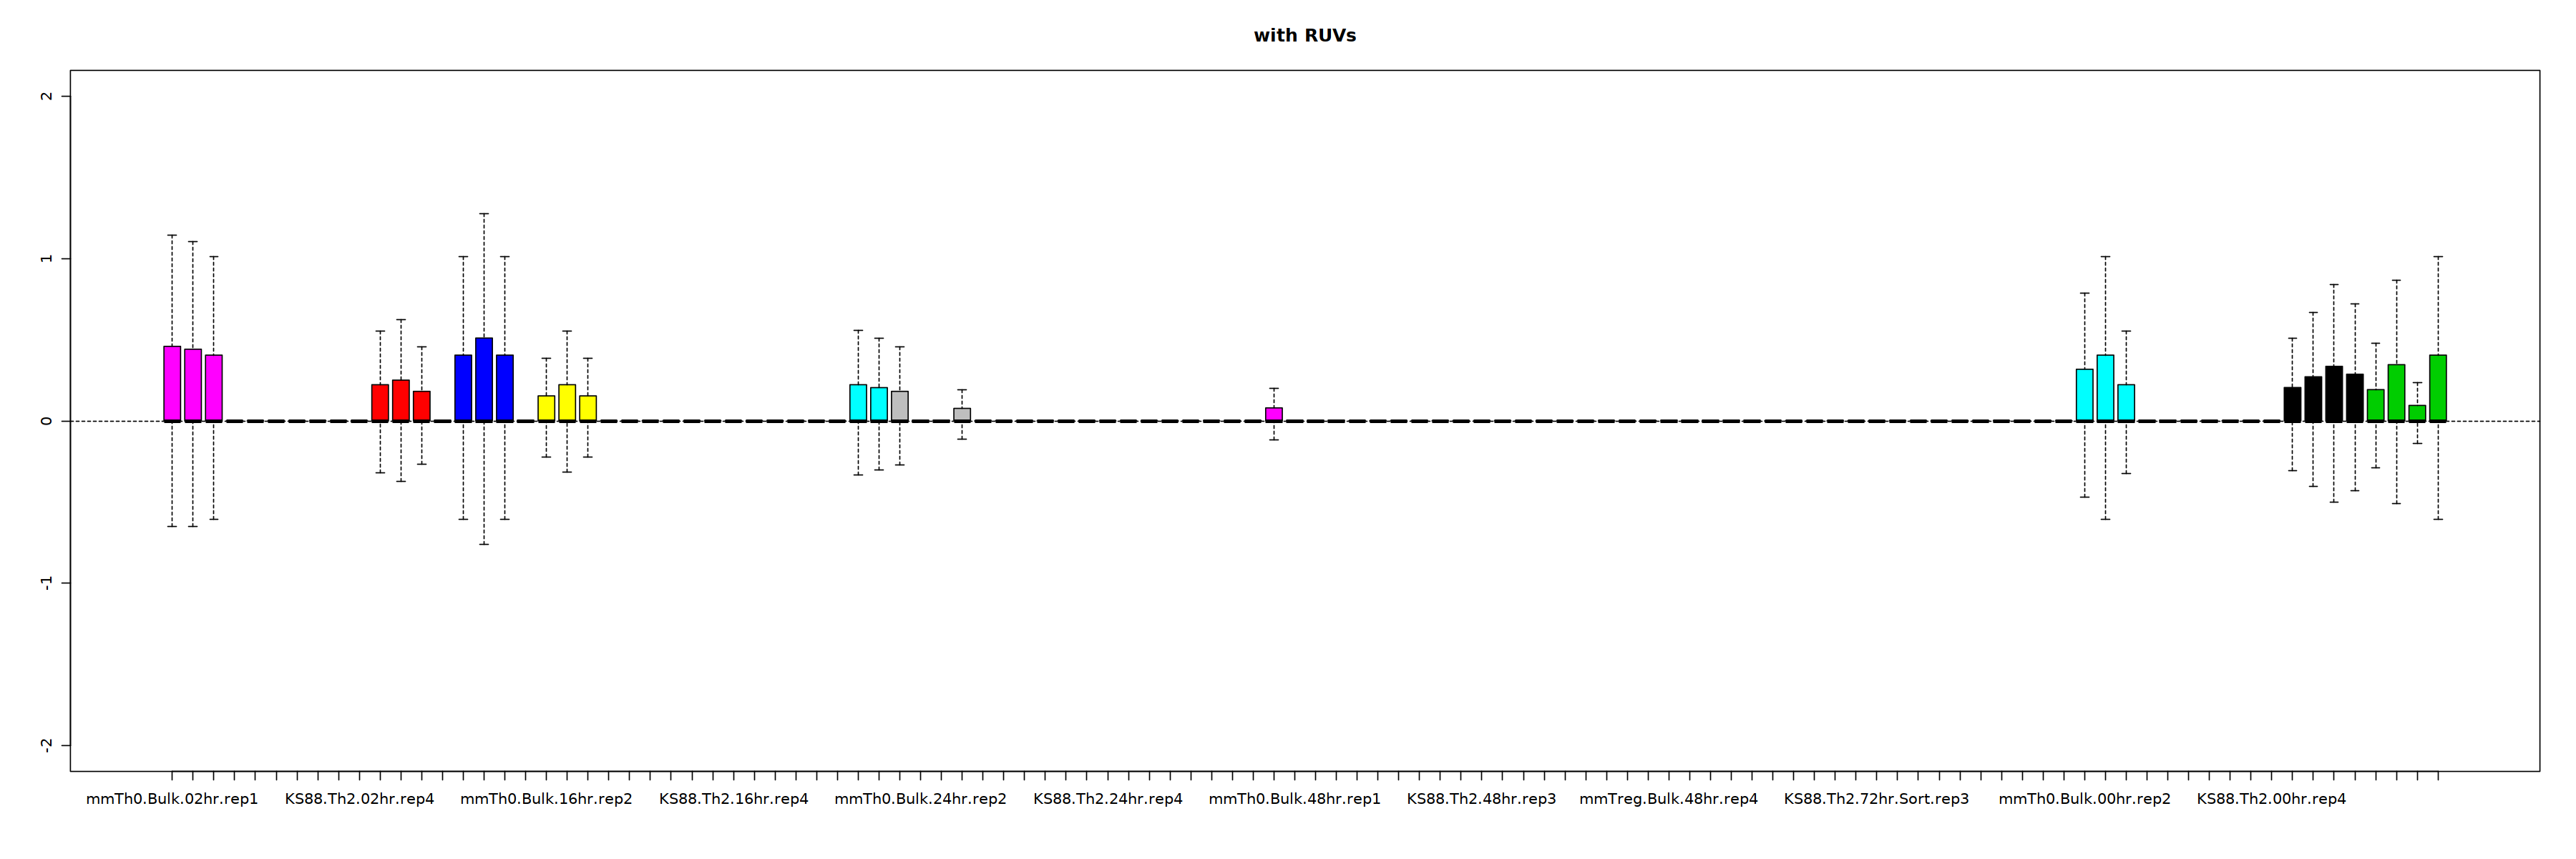

In [56]:
options(repr.plot.width=30, repr.plot.height=10)
plotRLE(set_for_00, outline=FALSE, ylim=c(-8,8), 
        col=as.numeric(colData_for_00$condition), 
        main = 'without RUVs')
plotRLE(set_ruv_00, outline=FALSE, ylim=c(-2,2), 
        col=as.numeric(colData_for_00$condition),
        main = 'with RUVs')

## RUVSeq for all cell types for timepoint 00hr

In [3]:
### countData

countData_time_00 <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/Tcell_timepoint_00.count.txt', sep='\t')
countData_time_00 <- countData_time_00[,-1]
rownames(countData_time_00) <- countData_time_00[,1]
countData_time_00[,1] <- NULL
countData_time_00 <- as.matrix(subset(countData_time_00))

### colData

col1_colData_00 <- as.vector(colnames(countData_time_00))
cond_colData_00 <- gsub('(.*)\\..*', '\\1', col1_colData_00)
rep_colData_00 <- gsub('.*\\.(.*)','\\1',col1_colData_00)
#day_colData_00 <- c(rep('day1',3),rep('day4',3),rep('day3',4),rep('day2',4),rep('day1',4))

colData_time_00 <- data.frame(condition = cond_colData_00,
                     rep = rep_colData_00, stringsAsFactors = TRUE)


rownames(colData_time_00) <- col1_colData_00


## create expression set for RUVSeq

set_time_00 <- newSeqExpressionSet(counts=countData_time_00,
                           phenoData = colData_time_00)
idx_time_00  <- rowSums(counts(set_time_00) > 5) >= 2
set_time_00 <- set_time_00[idx_time_00, ]

differences <- makeGroups(colData_time_00$condition)

# par(mfrow = c(2, 2))
# for(k in 1:4) {
#   set_s <- RUVs(set_Tcell, unique(rownames(set_Tcell)), 
#                 k=k, differences) #all genes
#   plotPCA(set_s, col=as.numeric(colData_Tcell$condition), 
#           cex = 0.9, adj = 0.5, 
#           main = paste0('with RUVs, k = ',k), 
#           ylim = c(-1, 1), xlim = c(-0.6, 0.6))
# }

set_00 <- RUVs(set_time_00, unique(rownames(set_time_00)), k=2, differences)
ruv_colData_time_00 <- pData(set_00)
ruv_colData_time_00$names <- rownames(ruv_colData_time_00)
#write.table(ruv_colData_time_00, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_data_00hr_day.txt'), quote = FALSE, row.names=TRUE, sep='\t')
# # ruv_colData_time_00$mean_weight <- rowMeans(ruv_colData_time_00[,c('W_1','W_2','W_3','W_4','W_5')], na.rm=TRUE)
# ruv_colData_time_00
ruv_colData_time_00
#colData_time_00


,condition,rep,W_1,W_2,names
mmTh0.Bulk.00hr.rep2,mmTh0.Bulk.00hr,rep2,-4.585813,-0.7114448,mmTh0.Bulk.00hr.rep2
mmTh0.Bulk.00hr.rep3,mmTh0.Bulk.00hr,rep3,-4.760560,-1.0557057,mmTh0.Bulk.00hr.rep3
mmTh0.Bulk.00hr.rep4,mmTh0.Bulk.00hr,rep4,-4.126693,-1.0489019,mmTh0.Bulk.00hr.rep4
KS191.Th1.00hr.rep1,KS191.Th1.00hr,rep1,-4.727475,-0.4887894,KS191.Th1.00hr.rep1
KS191.Th1.00hr.rep2,KS191.Th1.00hr,rep2,-4.637794,-0.3148416,KS191.Th1.00hr.rep2
KS191.Th1.00hr.rep3,KS191.Th1.00hr,rep3,-4.689749,-1.0648023,KS191.Th1.00hr.rep3
KS88.Th2.00hr.rep1,KS88.Th2.00hr,rep1,-4.696766,-0.6571111,KS88.Th2.00hr.rep1
KS88.Th2.00hr.rep2,KS88.Th2.00hr,rep2,-4.659057,-0.4955307,KS88.Th2.00hr.rep2
KS88.Th2.00hr.rep3,KS88.Th2.00hr,rep3,-4.613846,-1.2545760,KS88.Th2.00hr.rep3
KS88.Th2.00hr.rep4,KS88.Th2.00hr,rep4,-4.297744,-1.1345119,KS88.Th2.00hr.rep4


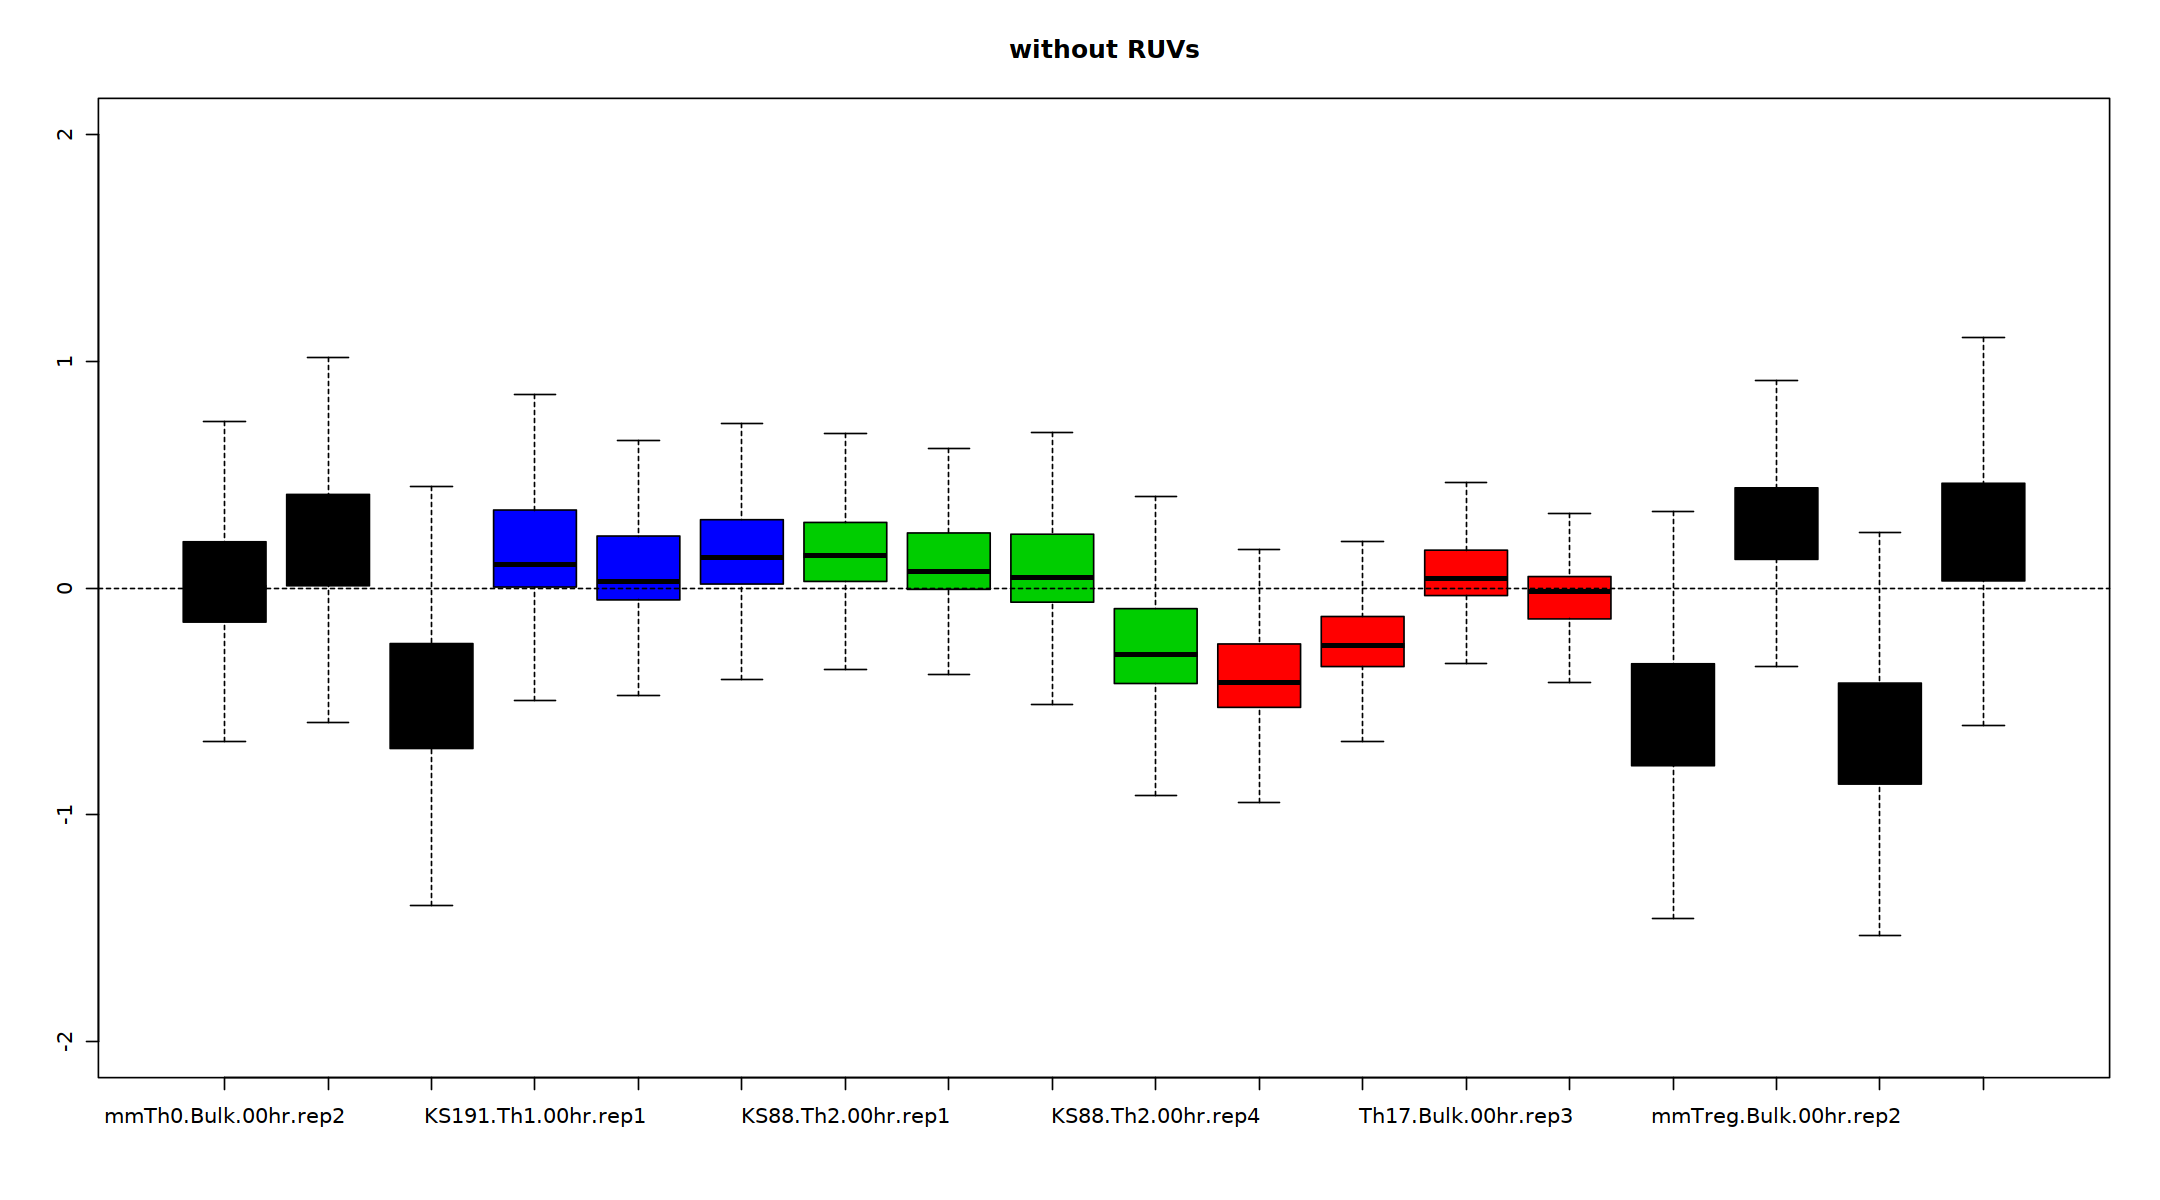

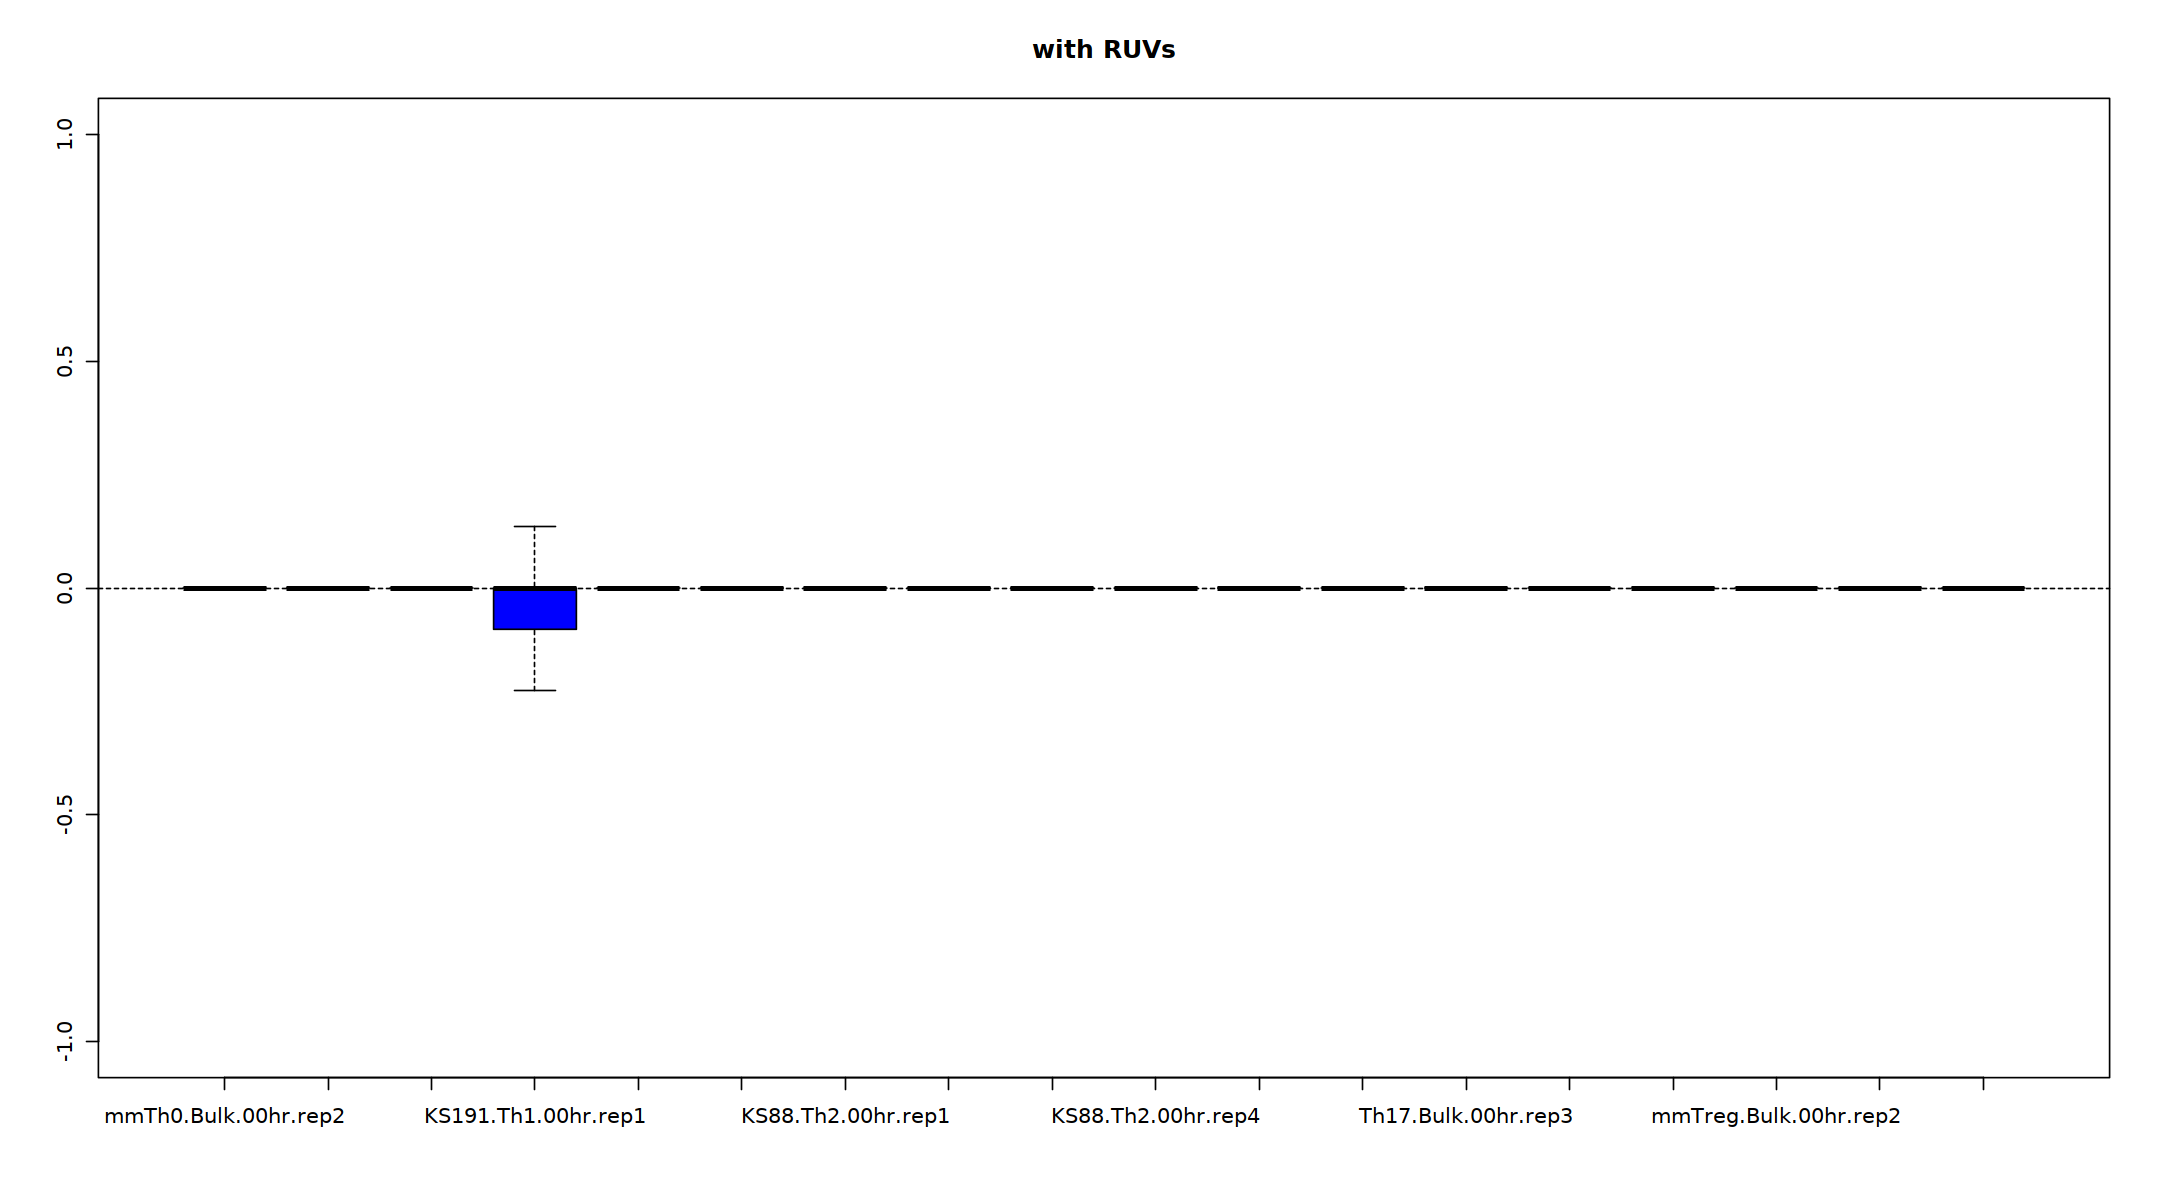

In [7]:
options(repr.plot.width=18, repr.plot.height=10)
plotRLE(set_time_00, outline=FALSE, ylim=c(-2,2), 
        col=as.numeric(colData_time_00$day), 
        main = 'without RUVs')
plotRLE(set_00, outline=FALSE, ylim=c(-1,1), 
        col=as.numeric(colData_time_00$day),
        main = 'with RUVs')

PCA plot for timepoint 00hr for all T cell subtypes

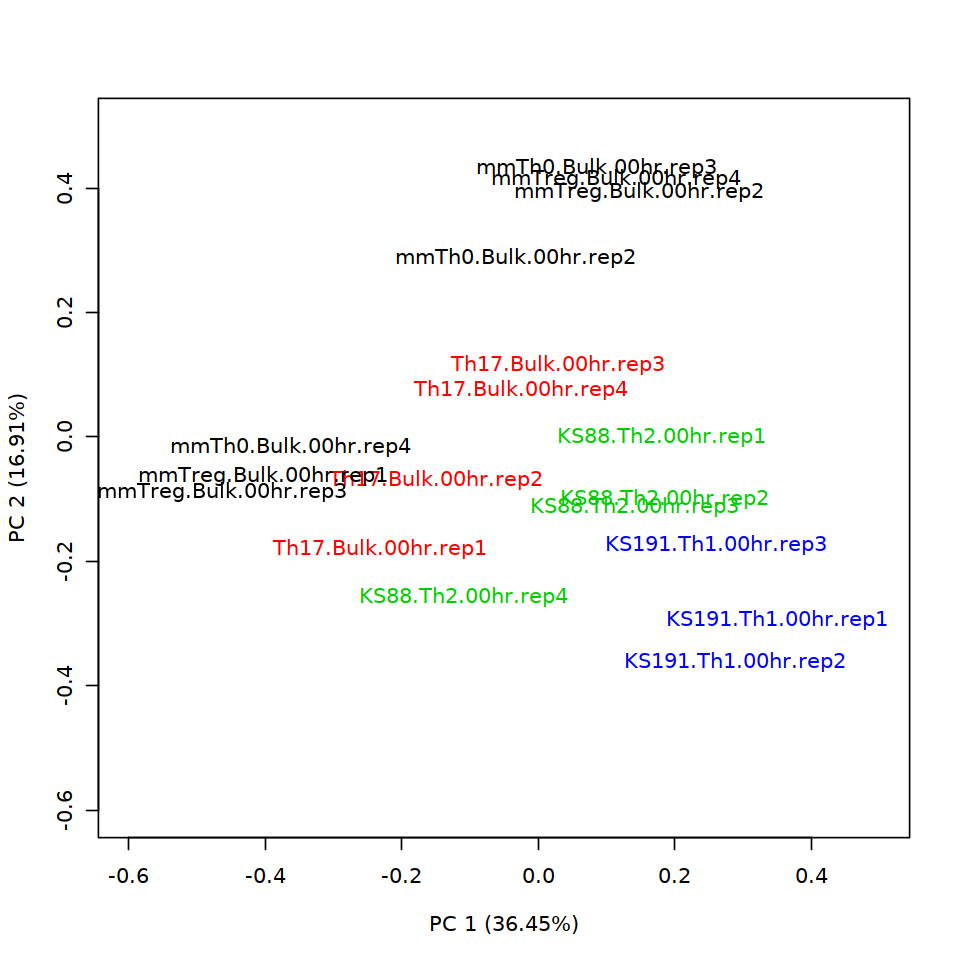

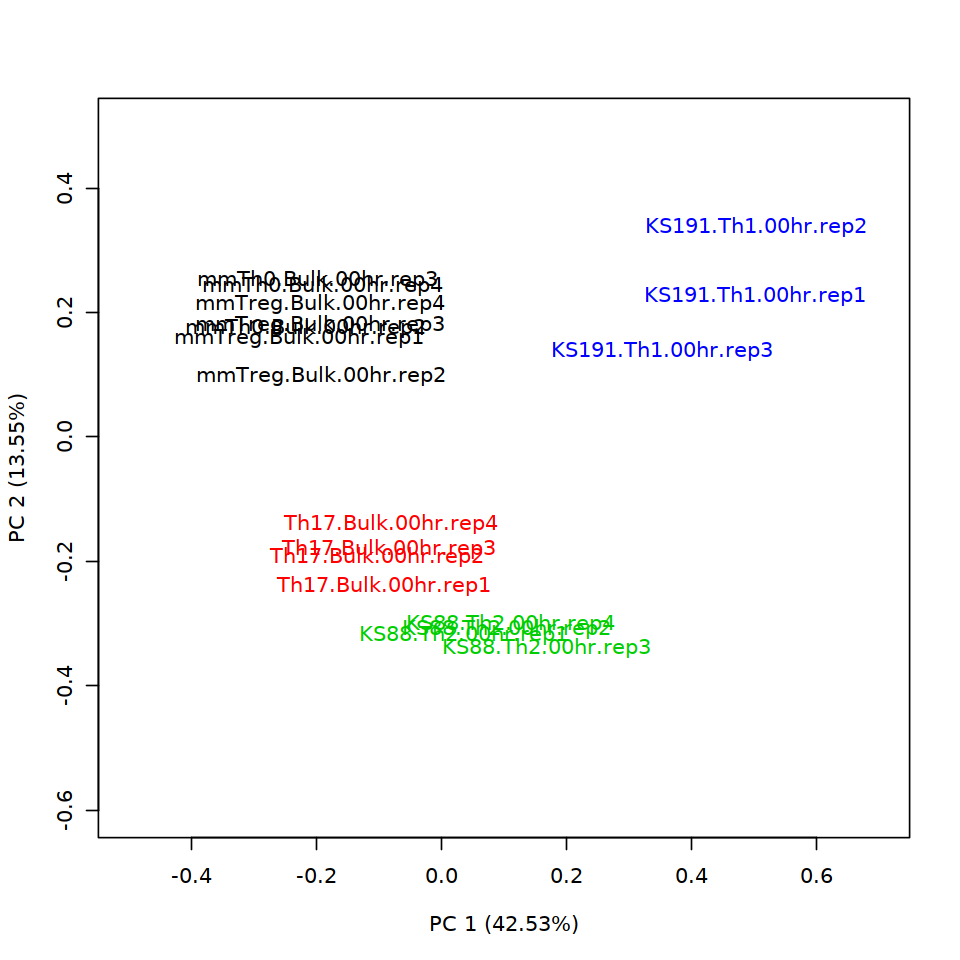

In [8]:
options(repr.plot.width=8, repr.plot.height=8)
plotPCA(set_time_00, col = as.numeric(colData_time_00$day), adj = 0.5, 
        ylim = c(-0.6, 0.5), xlim = c(-0.6, 0.5))
plotPCA(set_00, col = as.numeric(colData_time_00$day), adj = 0.5, 
        ylim = c(-0.6, 0.5), xlim = c(-0.5, 0.7))

Scale the countData with the scaling factors obtained from RUVSeq

In [9]:
#### create a table with the scaling factor

ruv_scale_factor <- ruv_colData_time_00[c(1:2,7)]
ruv_scale_factor$condition <- gsub('(.*)\\..*', '\\1', ruv_scale_factor$condition)
ruv_scale_factor$col_name <- paste(ruv_scale_factor$condition, ruv_scale_factor$rep, sep=".")
rownames(ruv_scale_factor)  <- ruv_scale_factor$col_name
col_name <- c('W_5')
ruv_scale_factor <- ruv_scale_factor[col_name]
write.table(ruv_scale_factor, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_correction_scaling_factor.txt'), quote = FALSE, row.names=TRUE, sep='\t')


Create scaling factor with 'W_1' from the ruvseq

In [10]:
ruv_scale_factor <- ruv_colData_time_00[c(1:3)]
ruv_scale_factor$condition <- gsub('(.*)\\..*', '\\1', ruv_scale_factor$condition)
ruv_scale_factor$col_name <- paste(ruv_scale_factor$condition, ruv_scale_factor$rep, sep=".")
rownames(ruv_scale_factor)  <- ruv_scale_factor$col_name
col_name <- c('W_1')
ruv_scale_factor <- ruv_scale_factor[col_name]
ruv_scale_factor <- abs(ruv_scale_factor)

write.table(ruv_scale_factor, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_correction_scaling_factor_v1.txt'), quote = FALSE, row.names=TRUE, sep='\t')


Create scaling factor with 'mean_weight' from the ruvseq

In [7]:
ruv_scale_factor <- ruv_colData_time_00[c(1:2,9)]
ruv_scale_factor$condition <- gsub('(.*)\\..*', '\\1', ruv_scale_factor$condition)
ruv_scale_factor$col_name <- paste(ruv_scale_factor$condition, ruv_scale_factor$rep, sep=".")
rownames(ruv_scale_factor)  <- ruv_scale_factor$col_name
col_name <- c('mean_weight')
ruv_scale_factor <- ruv_scale_factor[col_name]
ruv_scale_factor <- abs(ruv_scale_factor)
write.table(ruv_scale_factor, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_correction_scaling_factor_with_mean.txt'), quote = FALSE, row.names=TRUE, sep='\t')


Once the scaling factor was made, this was corrected to add all timepoints for the replicates of each subtype of Tcell. This was done using excel.<br>
The next task is to multiply for each subtype based on the replicate and timepoint, the scaling factor into the countTable for the DESeq analysis. I am going to do this in Python in this notebook [Th1_Th2_Th17_Treg_processing.ipynb](./Th1_Th2_Th17_Treg_processing.ipynb)

### DESeq after RUVSeq for all T cell subtypes

In [2]:
#### countData


countData_Tcell <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/Th1_Th2_Th17_Treg_Th0.counts.txt', sep='\t')
countData_Tcell <- countData_Tcell[,-1]
rownames(countData_Tcell) <- countData_Tcell[,1]
countData_Tcell[,1] <- NULL
#colnames(countData_Tcell)

### colData

Tcell_col1_colData <- as.vector(colnames(countData_Tcell))
Tcell_cond_colData <- gsub('(.*)\\..*', '\\1', Tcell_col1_colData)
Tcell_rep_colData <- gsub('.*\\.(.*)','\\1',Tcell_col1_colData)

colData_Tcell <- data.frame(condition = Tcell_cond_colData,
                     rep = Tcell_rep_colData, stringsAsFactors = TRUE)

rownames(colData_Tcell) <- Tcell_col1_colData
colData_Tcell$names <- rownames(colData_Tcell)

### merge colData to include the RUVSeq weights

ruv_colData_scaled <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_data_scaled.txt', sep='\t')
new_colData <- merge(x = ruv_colData_scaled, y = colData_Tcell, by = "names", all.y = TRUE)
new_colData <- new_colData[-c(2:4)]
rownames(new_colData) <- new_colData$names
new_colData[,1] <- NULL
colnames(new_colData)[c(5,6)] <- c("condition", "rep")

### reorder countData to match colData

genomic_idx <- match(rownames(new_colData), colnames(countData_Tcell))
countData_Tcell_ordered  <- countData_Tcell[ , genomic_idx]
colnames(countData_Tcell)


[1] "mmTh0.Bulk.02hr.rep1"       "mmTh0.Bulk.02hr.rep3"      
  [3] "mmTh0.Bulk.02hr.rep4"       "KS191.Th1.02hr.rep1"       
  [5] "KS191.Th1.02hr.rep2"        "KS191.Th1.02hr.rep3"       
  [7] "KS88.Th2.02hr.rep1"         "KS88.Th2.02hr.rep2"        
  [9] "KS88.Th2.02hr.rep3"         "KS88.Th2.02hr.rep4"        
 [11] "Th17.Bulk.02hr.rep1"        "Th17.Bulk.02hr.rep2"       
 [13] "Th17.Bulk.02hr.rep3"        "Th17.Bulk.02hr.rep4"       
 [15] "mmTreg.Bulk.02hr.rep2"      "mmTreg.Bulk.02hr.rep3"     
 [17] "mmTreg.Bulk.02hr.rep4"      "mmTh0.Bulk.16hr.rep1"      
 [19] "mmTh0.Bulk.16hr.rep2"       "mmTh0.Bulk.16hr.rep3"      
 [21] "mmTh0.Bulk.16hr.rep4"       "KS191.Th1.16hr.rep1"       
 [23] "KS191.Th1.16hr.rep2"        "KS191.Th1.16hr.rep3"       
 [25] "KS88.Th2.16hr.rep1"         "KS88.Th2.16hr.rep2"        
 [27] "KS88.Th2.16hr.rep3"         "KS88.Th2.16hr.rep4"        
 [29] "Th17.Bulk.16hr.rep1"        "Th17.Bulk.16hr.rep2"       
 [31] "Th17.Bulk.16hr.rep3"        "Th17.Bulk.16hr.rep4"       
 [33] "mmTreg.Bulk.16hr.rep2"      "mmTreg.Bulk.16hr.rep3"     
 [35] "mmTreg.Bulk.16hr.rep4"      "mmTh0.Bulk.24hr.rep1"      
 [37] "mmTh0.Bulk.24hr.rep2"       "mmTh0.Bulk.24hr.rep3"      
 [39] "mmTh0.Bulk.24hr.rep4"       "KS191.Th1.24hr.rep1"       
 [41] "KS191.Th1.24hr.rep2"        "KS191.Th1.24hr.rep3"       
 [43] "KS88.Th2.24hr.rep1"         "KS88.Th2.24hr.rep2"        
 [45] "KS88.Th2.24hr.rep3"         "KS88.Th2.24hr.rep4"        
 [47] "Th17.Bulk.24hr.rep1"        "Th17.Bulk.24hr.rep2"       
 [49] "Th17.Bulk.24hr.rep3"        "Th17.Bulk.24hr.rep4"       
 [51] "mmTreg.Bulk.24hr.rep1"      "mmTreg.Bulk.24hr.rep2"     
 [53] "mmTreg.Bulk.24hr.rep3"      "mmTreg.Bulk.24hr.rep4"     
 [55] "mmTh0.Bulk.48hr.rep1"       "mmTh0.Bulk.48hr.rep2"      
 [57] "mmTh0.Bulk.48hr.rep3"       "mmTh0.Bulk.48hr.rep4"      
 [59] "KS191.Th1.48hr.rep1"        "KS191.Th1.48hr.rep2"       
 [61] "KS191.Th1.48hr.rep3"        "KS88.Th2.48hr.rep1"        
 [63] "KS88.Th2.48hr.rep2"         "KS88.Th2.48hr.rep3"        
 [65] "KS88.Th2.48hr.rep4"         "Th17.Bulk.48hr.rep1"       
 [67] "Th17.Bulk.48hr.rep2"        "Th17.Bulk.48hr.rep3"       
 [69] "Th17.Bulk.48hr.rep4"        "mmTreg.Bulk.48hr.rep1"     
 [71] "mmTreg.Bulk.48hr.rep2"      "mmTreg.Bulk.48hr.rep3"     
 [73] "mmTreg.Bulk.48hr.rep4"      "mmTh0.Sorted.72hr.rep1"    
 [75] "mmTh0.Sorted.72hr.rep2"     "mmTh0.Sorted.72hr.rep3"    
 [77] "mmTh0.Sorted.72hr.rep4"     "KS191.Th1.72hr.Sorted.rep1"
 [79] "KS191.Th1.72hr.Sorted.rep2" "KS191.Th1.72hr.Sorted.rep3"
 [81] "KS88.Th2.72hr.Sort.rep1"    "KS88.Th2.72hr.Sort.rep2"   
 [83] "KS88.Th2.72hr.Sort.rep3"    "KS88.Th2.72hr.Sort.rep4"   
 [85] "Th17.Sorted.72hr.rep1"      "Th17.Sorted.72hr.rep2"     
 [87] "Th17.Sorted.72hr.rep3"      "Th17.Sorted.72hr.rep4"     
 [89] "mmTreg.Sorted.72hr.rep1"    "mmTreg.Sorted.72hr.rep2"   
 [91] "mmTreg.Sorted.72hr.rep3"    "mmTreg.Sorted.72hr.rep4"   
 [93] "mmTh0.Bulk.00hr.rep2"       "mmTh0.Bulk.00hr.rep3"      
 [95] "mmTh0.Bulk.00hr.rep4"       "KS191.Th1.00hr.rep1"       
 [97] "KS191.Th1.00hr.rep2"        "KS191.Th1.00hr.rep3"       
 [99] "KS88.Th2.00hr.rep1"         "KS88.Th2.00hr.rep2"        
[101] "KS88.Th2.00hr.rep3"         "KS88.Th2.00hr.rep4"        
[103] "Th17.Bulk.00hr.rep1"        "Th17.Bulk.00hr.rep2"       
[105] "Th17.Bulk.00hr.rep3"        "Th17.Bulk.00hr.rep4"       
[107] "mmTreg.Bulk.00hr.rep1"      "mmTreg.Bulk.00hr.rep2"     
[109] "mmTreg.Bulk.00hr.rep3"      "mmTreg.Bulk.00hr.rep4"

In [17]:
dds <- DESeqDataSetFromMatrix(countData = countData_Tcell_ordered, 
                                 colData = new_colData, 
                                 design = ~ W_1 + W_2 + W_3 + W_4 + rep + condition)


references <- c('00hr','02hr','16hr','24hr','48hr')
for (ref in references) {
    dds$condition <- relevel(dds$condition, ref = paste0('mmTh0.Bulk.',ref))
    dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 15, ]
    dds <- estimateSizeFactors(dds)
    dds <- estimateDispersions(dds, fitType='local')
    dds <- nbinomWaldTest(dds, maxit=100000)
    
    ##th2
    result_th2 <- results(dds, contrast = c('condition',paste0('KS88.Th2.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th2 <- result_th2[order(result_th2$padj),]
    result_th2 <- lfcShrink(dds, coef=paste0('condition_KS88.Th2.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th2, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th2.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
    
    ##th17
    result_th17 <- results(dds, contrast = c('condition',paste0('Th17.Bulk.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th17 <- result_th17[order(result_th17$padj),]
    result_th17 <- lfcShrink(dds, coef=paste0('condition_Th17.Bulk.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th17, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th17.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
    
    ##treg
    result_treg <- results(dds, contrast = c('condition',paste0('mmTreg.Bulk.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_treg <- result_treg[order(result_treg$padj),]
    result_treg <- lfcShrink(dds, coef=paste0('condition_mmTreg.Bulk.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_treg, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/mmTreg.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
    
    ##th1
    result_th1 <- results(dds, contrast = c('condition',paste0('KS191.Th1.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th1 <- result_th1[order(result_th1$padj),]
    result_th1 <- lfcShrink(dds, coef=paste0('condition_KS191.Th1.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th1, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th1.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
}


gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
5 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093

In [21]:

dds$condition <- relevel(dds$condition, ref = 'mmTh0.Sorted.72hr')
dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 15, ]
dds <- estimateSizeFactors(dds)
dds <- estimateDispersions(dds, fitType='local')
dds <- nbinomWaldTest(dds, maxit=100000)


result_th1 <- results(dds, contrast = c('condition','KS191.Th1.72hr.Sorted','mmTh0.Sorted.72hr'), alpha = 0.05)
result_th1 <- result_th1[order(result_th1$padj),]
result_th1 <- lfcShrink(dds, coef=paste0('condition_KS191.Th1.72hr.Sorted_vs_mmTh0.Sorted.72hr'), type='ashr')
write.table(result_th1, file='/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt', quote = FALSE, row.names=TRUE, sep = '\t')

result_th2 <- results(dds, contrast = c('condition','KS88.Th2.72hr.Sort','mmTh0.Sorted.72hr'), alpha = 0.05)
result_th2 <- result_th2[order(result_th2$padj),]
result_th2 <- lfcShrink(dds, coef=paste0('condition_KS88.Th2.72hr.Sort_vs_mmTh0.Sorted.72hr'), type='ashr')
write.table(result_th2, file='/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt', quote = FALSE, row.names=TRUE, sep = '\t')

result_th17 <- results(dds, contrast = c('condition','Th17.Sorted.72hr','mmTh0.Sorted.72hr'), alpha = 0.05)
result_th17 <- result_th17[order(result_th17$padj),]
result_th17 <- lfcShrink(dds, coef=paste0('condition_Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr'), type='ashr')
write.table(result_th17, file='/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt', quote = FALSE, row.names=TRUE, sep = '\t')

result_treg <- results(dds, contrast = c('condition','mmTreg.Sorted.72hr','mmTh0.Sorted.72hr'), alpha = 0.05)
result_treg <- result_treg[order(result_treg$padj),]
result_treg <- lfcShrink(dds, coef=paste0('condition_mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr'), type='ashr')
write.table(result_treg, file='/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt', quote = FALSE, row.names=TRUE, sep = '\t')



found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
6 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new d

In [30]:

result_th1 <- results(ddsruv, contrast = c('condition.x','KS191.Th1.02hr','mmTh0.Bulk.02hr'), alpha = 0.05)
result_th1 <- result_th1[order(result_th1$padj),]
result_th1 <- lfcShrink(ddsruv, coef=paste0('condition.x_KS191.Th1.02hr_vs_mmTh0.Bulk.02hr'), type='ashr')
write.table(result_th1, file='/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/Th1.Bulk.02hr_vs_mmTh0.Bulk.02hr.txt', quote = FALSE, row.names=TRUE, sep = '\t')


ERROR: Error in cleanContrast(object, contrast, expanded = isExpanded, listValues = listValues, : as mmTh0.Bulk.02hr is the reference level, was expecting condition.x_KS191.Th1.02hr_vs_mmTh0.Bulk.02hr to be present in 'resultsNames(object)'


In [16]:
resultsNames(ddsruv)

[1] "Intercept"                                           
 [2] "W_1"                                                 
 [3] "W_2"                                                 
 [4] "rep.x_rep2_vs_rep1"                                  
 [5] "rep.x_rep3_vs_rep1"                                  
 [6] "rep.x_rep4_vs_rep1"                                  
 [7] "condition.x_KS191.Th1.00hr_vs_mmTh0.Bulk.00hr"       
 [8] "condition.x_KS191.Th1.02hr_vs_mmTh0.Bulk.00hr"       
 [9] "condition.x_KS191.Th1.16hr_vs_mmTh0.Bulk.00hr"       
[10] "condition.x_KS191.Th1.24hr_vs_mmTh0.Bulk.00hr"       
[11] "condition.x_KS191.Th1.48hr_vs_mmTh0.Bulk.00hr"       
[12] "condition.x_KS191.Th1.72hr.Sorted_vs_mmTh0.Bulk.00hr"
[13] "condition.x_KS88.Th2.00hr_vs_mmTh0.Bulk.00hr"        
[14] "condition.x_KS88.Th2.02hr_vs_mmTh0.Bulk.00hr"        
[15] "condition.x_KS88.Th2.16hr_vs_mmTh0.Bulk.00hr"        
[16] "condition.x_KS88.Th2.24hr_vs_mmTh0.Bulk.00hr"        
[17] "condition.x_KS88.Th2.48hr_vs_mmTh0.Bulk.00hr"        
[18] "condition.x_KS88.Th2.72hr.Sort_vs_mmTh0.Bulk.00hr"   
[19] "condition.x_mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr"      
[20] "condition.x_mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr"      
[21] "condition.x_mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr"      
[22] "condition.x_mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr"      
[23] "condition.x_mmTh0.Sorted.72hr_vs_mmTh0.Bulk.00hr"    
[24] "condition.x_mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr"     
[25] "condition.x_mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr"     
[26] "condition.x_mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr"     
[27] "condition.x_mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr"     
[28] "condition.x_mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr"     
[29] "condition.x_mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr"   
[30] "condition.x_Th17.Bulk.00hr_vs_mmTh0.Bulk.00hr"       
[31] "condition.x_Th17.Bulk.02hr_vs_mmTh0.Bulk.00hr"       
[32] "condition.x_Th17.Bulk.16hr_vs_mmTh0.Bulk.00hr"       
[33] "condition.x_Th17.Bulk.24hr_vs_mmTh0.Bulk.00hr"       
[34] "condition.x_Th17.Bulk.48hr_vs_mmTh0.Bulk.00hr"       
[35] "condition.x_Th17.Sorted.72hr_vs_mmTh0.Bulk.00hr"

In [58]:
references <- c('00hr','02hr','16hr','24hr','48hr')
for (ref in references) {
    ddsruv$condition.x <- relevel(ddsruv$condition.x, ref = paste0('mmTh0.Bulk.',ref))
    ddsruv <- ddsruv[ rowSums(fpm(ddsruv, robust = FALSE)>=2) > 15, ]
    ddsruv <- estimateSizeFactors(ddsruv)
    ddsruv <- estimateDispersions(ddsruv, fitType='local')
    ddsruv <- nbinomWaldTest(ddsruv, maxit=100000)
    result_th17 <- results(ddsruv, contrast = c('condition.x',paste0('Th17.Bulk.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th17 <- result_th17[order(result_th17$padj),]
    result_th17 <- lfcShrink(ddsruv, coef=paste0('condition.x_Th17.Bulk.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th17, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/Th17.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
}


found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
11 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
9 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found already estimated dispersions, replacing these
gene-wise dispersion estim

In [60]:
references <- c('00hr','02hr','16hr','24hr','48hr')
for (ref in references) {
    ddsruv$condition.x <- relevel(ddsruv$condition.x, ref = paste0('mmTh0.Bulk.',ref))
    ddsruv <- ddsruv[ rowSums(fpm(ddsruv, robust = FALSE)>=2) > 15, ]
    ddsruv <- estimateSizeFactors(ddsruv)
    ddsruv <- estimateDispersions(ddsruv, fitType='local')
    ddsruv <- nbinomWaldTest(ddsruv, maxit=100000)
    result_treg <- results(ddsruv, contrast = c('condition.x',paste0('mmTreg.Bulk.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_treg <- result_treg[order(result_treg$padj),]
    result_treg <- lfcShrink(ddsruv, coef=paste0('condition.x_mmTreg.Bulk.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_treg, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/mmTreg.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
}


found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
11 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
10 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found already estimated dispersions, replacing these
gene-wise dispersion esti

In [66]:
references <- c('00hr','02hr','16hr','24hr','48hr')
for (ref in references) {
    ddsruv$condition.x <- relevel(ddsruv$condition.x, ref = paste0('mmTh0.Bulk.',ref))
    ddsruv <- ddsruv[ rowSums(fpm(ddsruv, robust = FALSE)>=2) > 15, ]
    ddsruv <- estimateSizeFactors(ddsruv)
    ddsruv <- estimateDispersions(ddsruv, fitType='local')
    ddsruv <- nbinomWaldTest(ddsruv, maxit=100000)
    result_th2 <- results(ddsruv, contrast = c('condition.x',paste0('KS88.Th2.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th2 <- result_th2[order(result_th2$padj),]
    result_th2 <- lfcShrink(ddsruv, coef=paste0('condition.x_KS88.Th2.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th2, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/Th2.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
}


found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
10 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
mean-dispersion relationship
final dispersion estimates
11 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
found already estimate

In [21]:
references <- c('02hr','16hr','24hr','48hr')
for (ref in references) {
    ddsruv$condition.x <- relevel(ddsruv$condition.x, ref = paste0('KS191.Th1.',ref))
    ddsruv <- ddsruv[ rowSums(fpm(ddsruv, robust = FALSE)>=2) > 15, ]
    ddsruv <- estimateSizeFactors(ddsruv)
    ddsruv <- estimateDispersions(ddsruv, fitType='local')
    ddsruv <- nbinomWaldTest(ddsruv, maxit=100000)
    result_th1 <- results(ddsruv, contrast = c('condition.x',paste0('KS191.Th1.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th1 <- result_th1[order(result_th1$padj),]
    result_th1 <- lfcShrink(ddsruv, coef=paste0('condition.x_KS191.Th1.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th1, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/Th1.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
}


found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
9 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest


ERROR: Error in lfcShrink(ddsruv, coef = paste0("condition.x_KS191.Th1.", ref, : coef %in% resultsNamesDDS is not TRUE


In [62]:
resultsNames(ddsruv)

[1] "Intercept"                                           
 [2] "W_1"                                                 
 [3] "W_2"                                                 
 [4] "rep.x_rep2_vs_rep1"                                  
 [5] "rep.x_rep3_vs_rep1"                                  
 [6] "rep.x_rep4_vs_rep1"                                  
 [7] "condition.x_mmTh0.Bulk.48hr_vs_mmTh0.Bulk.00hr"      
 [8] "condition.x_mmTh0.Bulk.24hr_vs_mmTh0.Bulk.00hr"      
 [9] "condition.x_mmTh0.Bulk.16hr_vs_mmTh0.Bulk.00hr"      
[10] "condition.x_mmTh0.Bulk.02hr_vs_mmTh0.Bulk.00hr"      
[11] "condition.x_KS191.Th1.0hr_vs_mmTh0.Bulk.00hr"        
[12] "condition.x_KS191.Th1.16hr_vs_mmTh0.Bulk.00hr"       
[13] "condition.x_KS191.Th1.24hr_vs_mmTh0.Bulk.00hr"       
[14] "condition.x_KS191.Th1.2hr_vs_mmTh0.Bulk.00hr"        
[15] "condition.x_KS191.Th1.48hr_vs_mmTh0.Bulk.00hr"       
[16] "condition.x_KS191.Th1.72hr.Sorted_vs_mmTh0.Bulk.00hr"
[17] "condition.x_KS88.Th2.0hr_vs_mmTh0.Bulk.00hr"         
[18] "condition.x_KS88.Th2.16hr_vs_mmTh0.Bulk.00hr"        
[19] "condition.x_KS88.Th2.24hr_vs_mmTh0.Bulk.00hr"        
[20] "condition.x_KS88.Th2.2hr_vs_mmTh0.Bulk.00hr"         
[21] "condition.x_KS88.Th2.48hr_vs_mmTh0.Bulk.00hr"        
[22] "condition.x_KS88.Th2.72hr.Sort_vs_mmTh0.Bulk.00hr"   
[23] "condition.x_mmTh0.Bulk.72hr_vs_mmTh0.Bulk.00hr"      
[24] "condition.x_mmTreg.Bulk.00hr_vs_mmTh0.Bulk.00hr"     
[25] "condition.x_mmTreg.Bulk.02hr_vs_mmTh0.Bulk.00hr"     
[26] "condition.x_mmTreg.Bulk.16hr_vs_mmTh0.Bulk.00hr"     
[27] "condition.x_mmTreg.Bulk.24hr_vs_mmTh0.Bulk.00hr"     
[28] "condition.x_mmTreg.Bulk.48hr_vs_mmTh0.Bulk.00hr"     
[29] "condition.x_mmTreg.Sorted.72hr_vs_mmTh0.Bulk.00hr"   
[30] "condition.x_Th17.Bulk.00hr_vs_mmTh0.Bulk.00hr"       
[31] "condition.x_Th17.Bulk.02hr_vs_mmTh0.Bulk.00hr"       
[32] "condition.x_Th17.Bulk.16hr_vs_mmTh0.Bulk.00hr"       
[33] "condition.x_Th17.Bulk.24hr_vs_mmTh0.Bulk.00hr"       
[34] "condition.x_Th17.Bulk.48hr_vs_mmTh0.Bulk.00hr"       
[35] "condition.x_Th17.Sorted.72hr_vs_mmTh0.Bulk.00hr"

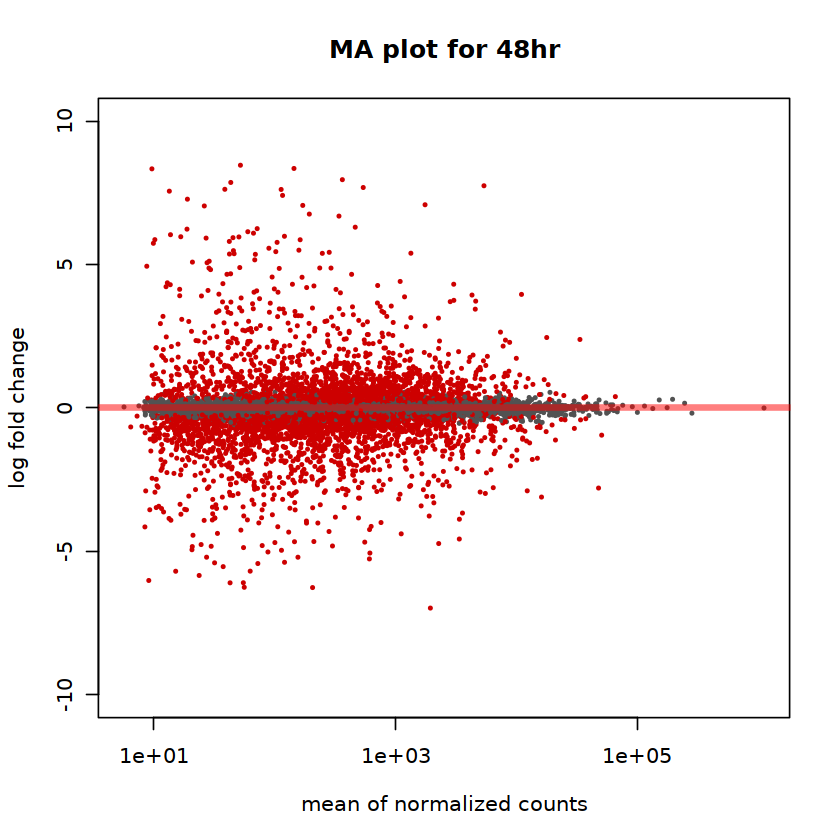

In [40]:
DESeq2::plotMA(test_result, main=paste0("MA plot for 48hr"), ylim = c(-10,10))

### DESeq after Scaling

In [2]:
### countTable before scaling

unscaled_countData <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/Th1_Th2_Th17_Treg_Th0.counts.txt', sep='\t')
unscaled_countData <- unscaled_countData[,-1]
rownames(unscaled_countData) <- unscaled_countData[,1]
unscaled_countData[,1] <- NULL
unscaled_countData <- as.matrix(subset(unscaled_countData))

### countTable after scaling 

scaled_countData <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_corrected_countTable.txt', sep='\t')
rownames(scaled_countData) <- scaled_countData[,1]
scaled_countData[,1] <- NULL
scaled_countData <- ceiling(scaled_countData)
scaled_countData <- as.matrix(subset(scaled_countData))
scaled_countData[scaled_countData < 0] <- 0
scaled_countData <- scaled_countData[rowSums(scaled_countData[])>0,]
scaled_countData <- scaled_countData+1

### countTable after scaling with weight W_1

scaled_countData_w1 <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_corrected_countTable_v1.txt', sep='\t')
rownames(scaled_countData_w1) <- scaled_countData_w1[,1]
scaled_countData_w1[,1] <- NULL
scaled_countData_w1 <- ceiling(scaled_countData_w1)
scaled_countData_w1 <- as.matrix(subset(scaled_countData_w1))
scaled_countData_w1[scaled_countData_w1 < 0] <- 0
scaled_countData_w1 <- scaled_countData_w1[rowSums(scaled_countData_w1[])>0,]
scaled_countData_w1 <- scaled_countData_w1+1

### countTable after scaling with mean_weight of all weights from ruvseq

scaled_countData_mean <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_corrected_countTable_mean.txt', sep='\t')
rownames(scaled_countData_mean) <- scaled_countData_mean[,1]
scaled_countData_mean[,1] <- NULL
scaled_countData_mean <- ceiling(scaled_countData_mean)
scaled_countData_mean <- as.matrix(subset(scaled_countData_mean))
scaled_countData_mean[scaled_countData_mean < 0] <- 0
scaled_countData_mean <- scaled_countData_mean[rowSums(scaled_countData_mean[])>0,]
scaled_countData_mean <- scaled_countData_mean + 1


### colData

col1_colData <- as.vector(colnames(scaled_countData_w1))
cond_colData <- gsub('(.*)\\..*', '\\1', col1_colData)
rep_colData <- gsub('.*\\.(.*)','\\1',col1_colData)


colData <- data.frame(condition = cond_colData,
                     rep = rep_colData, stringsAsFactors = TRUE)

rownames(colData) <- col1_colData

# ### DESeq analysis

# dds <- DESeqDataSetFromMatrix(countData = scaled_countData, 
#                                  colData = colData, 
#                                  design = ~ rep + condition)


# dds$condition <- relevel(dds$condition, ref = 'mmTh0.Sorted.72hr')
# dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 15, ]
# dds <- estimateSizeFactors(dds)
# dds <- estimateDispersions(dds, fitType='local')
# dds <- nbinomWaldTest(dds, maxit=100000)
    
# ##th2
# result_th2 <- results(dds, contrast = c('condition','KS88.Th2.72hr.Sort','mmTh0.Sorted.72hr'), alpha = 0.05)
# result_th2 <- result_th2[order(result_th2$padj),]
# result_th2 <- lfcShrink(dds, coef=paste0('condition_KS88.Th2.72hr.Sort_vs_mmTh0.Sorted.72hr'), type='ashr') 
# write.table(result_th2, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/W1/Th2.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
    
# ##th17
# result_th17 <- results(dds, contrast = c('condition','Th17.Sorted.72hr','mmTh0.Sorted.72hr'), alpha = 0.05)
# result_th17 <- result_th17[order(result_th17$padj),]
# result_th17 <- lfcShrink(dds, coef=paste0('condition_Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr'), type='ashr') 
# write.table(result_th17, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/W1/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
    
# ##treg
# result_treg <- results(dds, contrast = c('condition','mmTreg.Sorted.72hr','mmTh0.Sorted.72hr'), alpha = 0.05)
# result_treg <- result_treg[order(result_treg$padj),]
# result_treg <- lfcShrink(dds, coef=paste0('condition_mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr'), type='ashr') 
# write.table(result_treg, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/W1/mmTreg.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')
    
# ##th1
# result_th1 <- results(dds, contrast = c('condition','KS191.Th1.72hr.Sorted','mmTh0.Sorted.72hr'), alpha = 0.05)
# result_th1 <- result_th1[order(result_th1$padj),]
# result_th1 <- lfcShrink(dds, coef=paste0('condition_KS191.Th1.72hr.Sorted_vs_mmTh0.Sorted.72hr'), type='ashr') 
# write.table(result_th1, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/W1/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.txt'),
#             quote = FALSE, row.names=TRUE, sep = '\t')




## DESeq after RUVSeq when library prep day is used as covariate for correction 
#### Th1 results

In [34]:
### countData for all Tcell subtypes

countData_Tcell <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/Th1_Th2_Th17_Treg_Th0.counts.txt', sep='\t')
countData_Tcell <- countData_Tcell[,-1]
rownames(countData_Tcell) <- countData_Tcell[,1]
countData_Tcell[,1] <- NULL
countData_Th1 <- countData_Tcell[c(1:6,18:24,36:42,55:61,74:80,93:98)]
countData_Th1 <- as.matrix(subset(countData_Th1))

### colData for all Tcell subtypes

colData_Th1 <- read.csv('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/counts/ruvseq_data_00hr_day_scaled.txt', sep='\t')
rownames(colData_Th1) <- colData_Th1$X
colData_Th1 <- colData_Th1[c(2:3,5:6)]
colData_Th1 <- colData_Th1[-c(30),]

### reorder countData to match colData

genomic_idx <- match(rownames(colData_Th1), colnames(countData_Th1))
countData_Th1_ordered  <- countData_Th1[ , genomic_idx]
colData_Th1


,condition,rep,W_1,W_2
mmTh0.Sorted.72hr.rep1,mmTh0.Sorted.72hr,rep1,0.000000,0.0000000
mmTh0.Sorted.72hr.rep2,mmTh0.Sorted.72hr,rep2,-4.576715,-0.7352768
mmTh0.Sorted.72hr.rep3,mmTh0.Sorted.72hr,rep3,-4.750908,-1.0728830
mmTh0.Sorted.72hr.rep4,mmTh0.Sorted.72hr,rep4,-4.120691,-1.0876873
KS191.Th1.72hr.Sorted.rep1,KS191.Th1.72hr.Sorted,rep1,-4.712274,-0.4724661
KS191.Th1.72hr.Sorted.rep2,KS191.Th1.72hr.Sorted,rep2,-4.627213,-0.2814625
KS191.Th1.72hr.Sorted.rep3,KS191.Th1.72hr.Sorted,rep3,-4.674751,-1.0352790
mmTh0.Bulk.48hr.rep1,mmTh0.Bulk.48hr,rep1,0.000000,0.0000000
mmTh0.Bulk.48hr.rep2,mmTh0.Bulk.48hr,rep2,-4.576715,-0.7352768
mmTh0.Bulk.48hr.rep3,mmTh0.Bulk.48hr,rep3,-4.750908,-1.0728830


In [36]:
dds <- DESeqDataSetFromMatrix(countData = countData_Th1_ordered, 
                                 colData = colData_Th1, 
                                 design = ~ W_1 + W_2 + rep + condition)

references <- c('00hr','02hr','16hr','24hr','48hr')
for (ref in references) {
    dds$condition <- relevel(dds$condition, ref = paste0('mmTh0.Bulk.',ref))
    dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 15, ]
    dds <- estimateSizeFactors(dds)
    dds <- estimateDispersions(dds, fitType='local')
    dds <- nbinomWaldTest(dds, maxit=100000)
    result_th1 <- results(dds, contrast = c('condition',paste0('KS191.Th1.',ref),paste0('mmTh0.Bulk.',ref)), alpha = 0.05)
    result_th1 <- result_th1[order(result_th1$padj),]
    #result_th1 <- lfcShrink(dds, coef=paste0('condition_KS191.Th1.',ref,'_vs_mmTh0.Bulk.',ref), type='ashr') 
    write.table(result_th1, file=paste0('/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/with_day/Th1.Bulk.',ref,'_vs_mmTh0.Bulk.',ref,'.unshrunk.txt'),
            quote = FALSE, row.names=TRUE, sep = '\t')
}

dds$condition <- relevel(dds$condition, ref = 'mmTh0.Sorted.72hr')
dds <- dds[ rowSums(fpm(dds, robust = FALSE)>=2) > 15, ]
dds <- estimateSizeFactors(dds)
dds <- estimateDispersions(dds, fitType='local')
dds <- nbinomWaldTest(dds, maxit=100000)

result_th1_72 <- results(dds, contrast = c('condition','KS191.Th1.72hr.Sorted','mmTh0.Sorted.72hr'), alpha = 0.05)
result_th1_72 <- result_th1_72[order(result_th1_72$padj),]
#result_th1_72 <- lfcShrink(dds, coef=paste0('condition_KS191.Th1.72hr.Sorted_vs_mmTh0.Sorted.72hr'), type='ashr')
write.table(result_th1_72, file='/data/reddylab/Revathy/collabs/Keith/Tcell/data/rna_seq/deseq/all/with_day/Th1.Sorted.72hr_vs_mmTh0.Sorted.72hr.unshrunk.txt', quote = FALSE, row.names=TRUE, sep = '\t')



gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
